<a href="https://colab.research.google.com/github/florianezanella/nlp_project_sentiment_analysis/blob/main/NLP_ENSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Required Libraries
!pip install transformers datasets scikit-learn pandas tqdm -q

In [ ]:
# Step 2: Download and Extract the IMDb Dataset
import os
import tarfile
import urllib.request

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()
    print("Dataset downloaded and extracted.")

In [ ]:
# Step 3: Load and Format the Dataset into a Pandas DataFrame
import glob
import pandas as pd

def load_imdb_data(data_dir):
    def load_dir(path, label):
        texts = []
        for filepath in glob.glob(os.path.join(path, "*.txt")):
            with open(filepath, encoding='utf-8') as f:
                texts.append(f.read())
        return pd.DataFrame({"text": texts, "label": label})

    pos = load_dir(os.path.join(data_dir, "pos"), 1)
    neg = load_dir(os.path.join(data_dir, "neg"), 0)
    return pd.concat([pos, neg])

train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df


,text,label
0,Made me wish my own happy birds could talk. Ti...,1
1,Now I'll be the first to admit it when I say s...,0
2,I love this movie and never get tired of watch...,1
3,I think that the shots and lighting were very ...,0
4,"I sat through this movie this evening, forcing...",0
...,...,...
24995,I'm not alone in admiring the first Superman m...,0
24996,Another Spanish movie about the 1936 Civil War...,1
24997,"It's awesome! In Story Mode, your going from p...",1
24998,German nut case Jörg Buttgereit apparently has...,0


In [ ]:
# Step 4: Convert to HuggingFace Dataset Format
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
# Step 5: Tokenization using BERT
from transformers import BertTokenizer

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

#train_tokenized = train_dataset.map(tokenize, batched=True)
#test_tokenized = test_dataset.map(tokenize, batched=True)


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
# Step 6: Prepare Torch Datasets
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [ ]:
# Step 7: Load BERT and Trainer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments


training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-133ee0e38b5c>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Step 8: Fine-Tune BERT
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: paul-d10 (paul-d10-ensae-alumni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.278600,0.279022
2,0.146800,0.276784


TrainOutput(global_step=6250, training_loss=0.2376687759399414, metrics={'train_runtime': 3050.0417, 'train_samples_per_second': 16.393, 'train_steps_per_second': 2.049, 'total_flos': 6623369932800000.0, 'train_loss': 0.2376687759399414, 'epoch': 2.0})

In [ ]:
# Save model after training
model_save_path = "./imdb_sentiment_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Save training arguments using the to_json_string method instead
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model


In [ ]:
# Zip the model directory
!zip -r imdb_sentiment_model.zip {model_save_path}

# Download the zip file
from google.colab import files
files.download('imdb_sentiment_model.zip')

  adding: imdb_sentiment_model/ (stored 0%)
  adding: imdb_sentiment_model/model.safetensors (deflated 8%)
  adding: imdb_sentiment_model/vocab.txt (deflated 53%)
  adding: imdb_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: imdb_sentiment_model/training_args.bin (deflated 52%)
  adding: imdb_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: imdb_sentiment_model/training_args.json (deflated 63%)
  adding: imdb_sentiment_model/config.json (deflated 45%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 9: Predict Scores for Test Set
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

test_loader = DataLoader(test_tokenized, batch_size=16)
model.eval()

all_preds = []
all_scores = []
all_texts = test_df["text"].tolist()

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'label'}
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # Positive score


100%|██████████| 1563/1563 [05:44<00:00,  4.53it/s]


In [ ]:
# Step 10: Create Final Scored DataFrame
scored_df = pd.DataFrame({
    "review": all_texts,
    "predicted_sentiment": all_preds,
    "positive_score": all_scores
})

scored_df.head()


,review,predicted_sentiment,positive_score
0,"This movie was fun, if all over the board.<br ...",1,0.997023
1,"Yes, Lifetime has a habit of making the male s...",0,0.000844
2,What a great show! A very underrated dramatic ...,1,0.999279
3,Would it surprise you that my ears and eyes al...,0,0.000708
4,I'm going to be generous here and give it a 3 ...,0,0.001171


In [ ]:
# Step 11: Evaluate the model on the test set
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9316
Precision: 0.9335
Recall: 0.9295
F1 Score: 0.9315


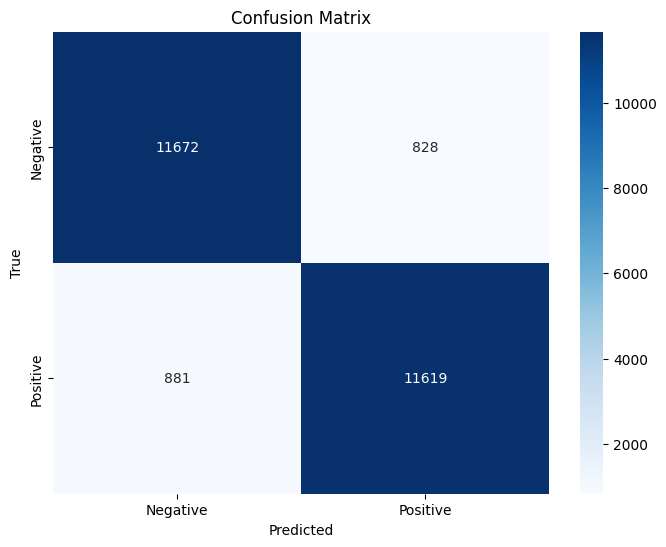

In [ ]:
# Create confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Plot some example predictions
def show_example_predictions(dataset, predictions, num_examples=10):
    indices = np.random.choice(range(len(dataset)), num_examples, replace=False)
    for idx in indices:
        text = dataset[idx]['text']
        true_label = "Positive" if dataset[idx]['label'] == 1 else "Negative"
        pred_label = "Positive" if preds[idx] == 1 else "Negative"
        confidence = predictions.predictions[idx].max()

        print(f"Review: {text[:100]}...")
        print(f"True sentiment: {true_label}")
        print(f"Predicted sentiment: {pred_label}")
        print(f"Confidence: {confidence:.4f}")
        print("-" * 80)

# Show examples of correct and incorrect predictions
correct_indices = np.where(preds == labels)[0]
incorrect_indices = np.where(preds != labels)[0]

print("\n=== CORRECTLY CLASSIFIED EXAMPLES ===")
if len(correct_indices) > 0:
    correct_sample = np.random.choice(correct_indices, min(10, len(correct_indices)), replace=False)
    for idx in correct_sample:
        text = test_df.iloc[idx]['text']
        true_label = "Positive" if test_df.iloc[idx]['label'] == 1 else "Negative"
        pred_label = "Positive" if preds[idx] == 1 else "Negative"

        print(f"Review: {text[:150]}...")
        print(f"True sentiment: {true_label}")
        print(f"Predicted sentiment: {pred_label}")
        print(f"Confidence: {predictions.predictions[idx].max()}")
        print(f"Positive score : {all_scores[idx]}")
        print("-" * 80)

print("\n=== INCORRECTLY CLASSIFIED EXAMPLES ===")
if len(incorrect_indices) > 0:
    incorrect_sample = np.random.choice(incorrect_indices, min(10, len(incorrect_indices)), replace=False)
    for idx in incorrect_sample:
        text = test_df.iloc[idx]['text']
        true_label = "Positive" if test_df.iloc[idx]['label'] == 1 else "Negative"
        pred_label = "Positive" if preds[idx] == 1 else "Negative"

        print(f"Review: {text[:150]}...")
        print(f"True sentiment: {true_label}")
        print(f"Predicted sentiment: {pred_label}")
        print(f"Confidence: {predictions.predictions[idx].max()}")
        print(f"Positive score : {all_scores[idx]}")
        print("-" * 80)



=== CORRECTLY CLASSIFIED EXAMPLES ===
Review: A kooky, but funny bit of diversion. You kind of have to see it from the beginning to follow what's happening, but each report to earth has it's own l...
True sentiment: Positive
Predicted sentiment: Positive
Confidence: 1.1718584299087524
Positive score : 0.9259997010231018
--------------------------------------------------------------------------------
Review: I watched the pilot episode for this one with high expectations, having just graduated college and moved on to "real life". I was not in a fraternity,...
True sentiment: Positive
Predicted sentiment: Positive
Confidence: 1.8791204690933228
Positive score : 0.9817125201225281
--------------------------------------------------------------------------------
Review: Niñas Mal is not a movie is a bad episode of a cheesy badly conceived soap opera. <br /><br />The acting is not a bit better of that in soap operas, I...
True sentiment: Negative
Predicted sentiment: Negative
Confidence: 3.

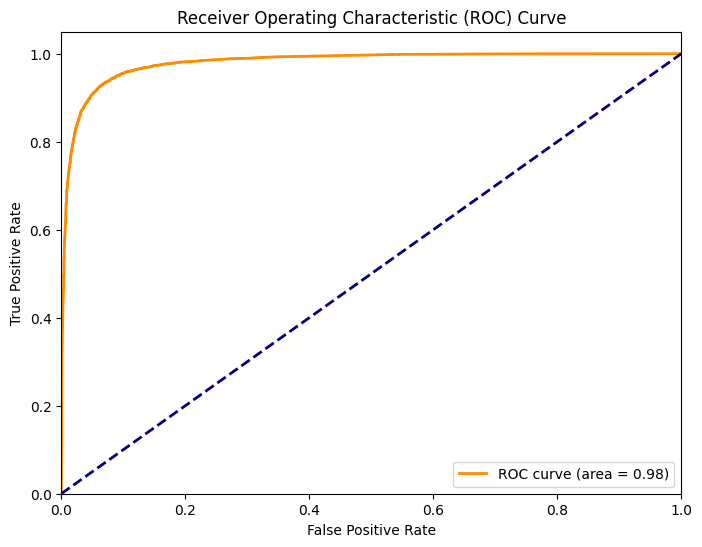

In [ ]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# Get the probabilities for the positive class
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install beautifulsoup4 requests -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 14.5 MB/s eta 0:00:00


In [ ]:
!pip uninstall imdbpy
!pip install -U git+https://github.com/cinemagoer/cinemagoer

Found existing installation: IMDbPY 2022.7.9
Uninstalling IMDbPY-2022.7.9:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/IMDbPY-2022.7.9.dist-info/*
Proceed (Y/n)? y
  Successfully uninstalled IMDbPY-2022.7.9
  Cloning https://github.com/cinemagoer/cinemagoer to /tmp/pip-req-build-vqh7pc9j
  Running command git clone --filter=blob:none --quiet https://github.com/cinemagoer/cinemagoer /tmp/pip-req-build-vqh7pc9j
  Resolved https://github.com/cinemagoer/cinemagoer to commit 920e956d06a84b7522bad595b3dc48fed43bcf56
  Preparing metadata (setup.py) ... done
  Created wheel for cinemagoer: filename=cinemagoer-2023.10.22-py3-none-any.whl size=298340 sha256=b0063f13dda9332906e42c6339e73a30bdc0fc72a03be3cb72f3a7f72e8384d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-akoi6xrf/wheels/57/da/e7/1e46a9c898b12644f1c2cdb4cd1af297a2ac4415d09d6a807f
Successfully built cinemagoer
  Attempting uninstall: cinemagoer
    Found existing installation: cinemagoer 2023.5.1
    Uninstalling ci

2nd part

In [ ]:
synopsis_df

,title,plot,synopsis,rating
0,The Shawshank Redemption,A banker convicted of uxoricide forms a friend...,"In 1947, Andy Dufresne (Tim Robbins), a banker...",9.3
1,The Godfather,The aging patriarch of an organized crime dyna...,"In 1945, while his daughter Connie is getting ...",9.2
2,The Dark Knight,When a menace known as the Joker wreaks havoc ...,A gang of 6 criminals rob a Gotham City mob ba...,9.0
3,The Godfather Part II,The early life and career of Vito Corleone in ...,Events from Vito Corleone's early life and som...,9.0
4,12 Angry Men,The jury in a New York City murder trial is fr...,The story begins in a courtroom where an 18-ye...,9.0
5,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...,"In the opening scene, Smeagol (Andy Serkis) an...",9.0
6,Schindler's List,"In German-occupied Poland during World War II,...",The relocation of Polish Jews from surrounding...,9.0
7,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",Narrative structure\nPulp Fiction's narrative ...,8.9
8,The Lord of the Rings: The Fellowship of the Ring,A meek Hobbit from the Shire and eight compani...,Galadriel (Cate Blanchett) (The Elven co-ruler...,8.9
9,"The Good, the Bad and the Ugly",A bounty-hunting scam joins two men in an unea...,In a desolate ghost town during the American C...,8.8


In [ ]:
movie = ia.get_movie('0111161')  # The Shawshank Redemption
ia.update(movie, info=['main', 'plot'])
print(movie['title'], movie.get('plot', [""])[0], movie.get('rating'))


The Shawshank Redemption A banker convicted of uxoricide forms a friendship over a quarter century with a hardened convict, while maintaining his innocence and trying to remain hopeful through simple compassion. 9.3


In [ ]:
# Remove movies with mid/neutral scores (e.g., between 4.5 and 6.5)
filtered_df = synopsis_df[(synopsis_df["rating"] <= 4.5) | (synopsis_df["rating"] >= 6.5)].reset_index(drop=True)

# Normalize rating between 0 and 1 for regression
filtered_df["rating_normalized"] = filtered_df["rating"] / 10.0

filtered_df.head()
